# NLP Project 2, Seek dataset Category and Job Type Classification
22274048, 23191175

First, import all required libraries and modules for the project and load the data into pandas

In [3]:
!pip install ftfy
import ftfy

In [4]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/omriram/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
import pandas as pd
import numpy as np
import pandas as pd
import os
from argparse import Namespace
import random
import os
import torch.nn.functional as F
import pandas as pd
import unicodedata
import gensim
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from time import time
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource, LabelSet
from nltk.corpus import stopwords
from tqdm.notebook import tqdm
from gensim.models import KeyedVectors
stopwords = stopwords.words('english')

Find the root directory of the project

In [6]:
script_dir = os.path.dirname(os.path.realpath('__file__'))
script_dir

'/Users/omriram/Desktop/submission'

define some global parameters for cleaning and preparing the data

In [7]:
df_args = Namespace(
    unprocessed_csv  = os.path.join(script_dir, 'data/seek_australia.csv'),
    processed_csv = os.path.join(script_dir, 'data/processed_seek.csv'),
    train_proportion=0.7,
    val_proportion=0.1,
    test_proportion=0.2,
    frac = 1, # change to 1 to use the full dataset
)

In [8]:
#import ftfy
df = pd.read_csv (df_args.unprocessed_csv)
df = df.sample(frac=df_args.frac, ignore_index=True, random_state=1) # this also shuffles the dataframe
df

,category,city,company_name,geo,job_board,job_description,job_title,job_type,post_date,salary_offered,state,url
0,Trades & Services,"Newcastle, Maitland & Hunter",The Local Bloke Lawn & Garden Care,AU,seek,Newcastle Location Car License Required Previ...,Lawn & Garden Care Position,Casual/Vacation,2018-04-16T01:15:22Z,NaN,NaN,https://www.seek.com.au/job/35990983
1,"Manufacturing, Transport & Logistics",Sydney,B&J City Kitchen Pty Ltd,AU,seek,Beak & Johnston are industry leaders within t...,Machine Operator - Food Manufacturing,Full Time,2018-04-13T03:00:07Z,NaN,Parramatta & Western Suburbs,https://www.seek.com.au/job/35978566
2,Community Services & Development,Katherine & Northern Australia,YMCA of the Northern Territory,AU,seek,"The Opportunity Do you enjoy a challenge, lov...",Youth Diversion Worker,Full Time,2018-04-11T03:50:48Z,NaN,NaN,https://www.seek.com.au/job/35957875
3,Real Estate & Property,Sydney,Dexus,AU,seek,Work on one of the best property portfolios i...,Communications and Investor Development Manager,Full Time,2018-04-15T23:10:56Z,NaN,"CBD, Inner West & Eastern Suburbs",https://www.seek.com.au/job/35989342
4,Hospitality & Tourism,Cairns & Far North,Hays Trades & Labour,AU,seek,Permanent position on offer for a Junior Sous...,Junior Sous Chef,Full Time,2018-04-12T02:07:23Z,NaN,NaN,https://www.seek.com.au/job/35967182
...,...,...,...,...,...,...,...,...,...,...,...,...
29995,Information & Communication Technology,Sydney,Hays Information Technology,AU,seek,Junior .Net Developer required for a start-up...,Junior .Net Developer,Contract/Temp,2018-04-13T06:19:44Z,NaN,"CBD, Inner West & Eastern Suburbs",https://www.seek.com.au/job/35982781
29996,Trades & Services,Melbourne,Zoom Recruitment & Training,AU,seek,We are seeking general labourers/ hands for v...,General Labourers,Contract/Temp,2018-04-16T06:42:38Z,NaN,Bayside & South Eastern Suburbs,https://www.seek.com.au/job/35997078
29997,Sales,Melbourne,Recruitmore VIC,AU,seek,No industry experience? No worries! Use your ...,IMMEDIATE STARTS - SALES & CUSTOMER SERVICE,Contract/Temp,2018-04-14T23:00:07Z,NaN,CBD & Inner Suburbs,https://www.seek.com.au/job/35987014
29998,Construction,Sydney,Hays Construction,AU,seek,This large building construction firm are loo...,Senior Contract Administrator,Full Time,2018-04-16T02:44:21Z,NaN,"CBD, Inner West & Eastern Suburbs",https://www.seek.com.au/job/35992778


## Data preprocessing

#### Preparing the dataframe for classification

Remove unnecessary columns

In [9]:
features_to_delete = ['job_board','geo','url', 'city', 'post_date', 'salary_offered', 'state', "company_name", "job_title"] # get rid of unnecessary features (maybe add more columns)
df = df.drop(features_to_delete, axis=1)

Retrieve the number of null values in each column

In [10]:
df.isna().sum()

category             0
job_description    345
job_type             0
dtype: int64

Job description is the feature column and will be used for all the classification tasks, thus all rows that are missing values for the column can be dropped

In [11]:
df.dropna(subset=['job_description'], inplace=True)

Decode the text in the job description column and use gensim for tokenization

In [12]:
for i in tqdm(df[ "job_description"].index):
    df.loc[i, "job_description"] = gensim.utils.simple_preprocess(
        ftfy.fix_text(unicodedata.normalize("NFKD",df.loc[i,"job_description"])), deacc=True)

  0%|          | 0/29655 [00:00<?, ?it/s]

Create_tfidf function creates a dataframe with each row representing a document with corresponding tfidf scores and the columns showing the full corpus vocabulary. Thus the tfidf score for each word in each document can be retrieved.

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Allows passing tokens to the vectorizer
def dummy_fun(doc):
    return doc

def create_tfidf_df(tokens):  
    """
    Returns a bag of words data frame to fetch the tfidf score for each document
    tokens: the corpus as a list of tokens
    """
    from nltk.corpus import stopwords
    stopwords = stopwords.words('english')
    tfidf = TfidfVectorizer(
    analyzer='word',
    tokenizer=dummy_fun,
    preprocessor=dummy_fun,
    token_pattern=None,
    stop_words=stopwords) 

    tdf = tfidf.fit_transform(tokens)
    bow = pd.DataFrame(tdf.toarray(), columns = tfidf.get_feature_names_out())

    return bow

Here all words in each description are ranked according to their tfidf scores. All words that do not have a score that is in the top 10 are subsequently removed. Tfidf calculation treats each category as its own corpus

In [14]:
df['short_description'] = [None for i in range(len(df))]
def top_x_tfidf(df, x):
    """
    df is the dataframe to modify, x represents the top x words to leave in each document. Returns a list of documents as tokens. 
    """
    for category in tqdm(df.category.unique()):
        tfidf_df = create_tfidf_df(df[df.category == category]['job_description'])
        col_names= set(tfidf_df.columns)
        for i, (idx_row) in enumerate(df[df.category == category].iterrows()):
            idx, row = idx_row
            desc = row['job_description']
            words = set(desc)        
            if len(words) < x: 
                df.loc[idx]['short_description'] = words
                continue
            words = words.intersection(col_names)

            # Create a dictionary of words and their tfidf values and then sort them in descending order
            tfidf_words = {word: tfidf_df.iloc[i][word] for word in words}
            tfidf_words = {k: v for k, v in sorted(tfidf_words.items(), key=lambda item: -item[1])}

            for word in desc:
                if word not in list(tfidf_words.keys())[:x]: # Remove all words who are not in the top ten tfidf scores
                    desc = list(filter(lambda x: x != word, desc))
            df.loc[idx]['short_description'] = desc
    return df['short_description']
df['short_description'] = top_x_tfidf(df, 10)
df['short_description']

  0%|          | 0/30 [00:00<?, ?it/s]

/Users/omriram/Desktop/U/cits4012/cits4012_environment/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'", 'b', 'c', 'e', 'f', 'g', 'h', 'j', 'l', 'n', 'p', 'r', 'u', 'v', 'w'] not in stop_words.
  warnings.warn(
/Users/omriram/Desktop/U/cits4012/cits4012_environment/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'", 'b', 'c', 'e', 'f', 'g', 'h', 'j', 'l', 'n', 'p', 'r', 'u', 'v', 'w'] not in stop_words.
  warnings.warn(
/Users/omriram/Desktop/U/cits4012/cits4012_environment/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'", 'b', 'c', 'e', 'f', 'g', 'h', 'j', 'l', 'n', 'p', 

0        [advantage, lawn, regards, strictly, smoking, ...
1        [beak, within, chilled, food, beak, food, manu...
2        [young, people, ymca, territory, youth, commun...
3        [dexus, communications, funds, communications,...
4        [permanent, junior, sous, chef, popular, touri...
                               ...                        
29995    [net, start, start, youa, tmll, net, developme...
29996    [general, labourers, hands, various, assignmen...
29997    [industry, people, face, face, industry, youa,...
29998    [sydeny, cbd, new, builder, developer, yearsa,...
29999    [anzuk, melbourne, melbourne, teaching, second...
Name: short_description, Length: 29655, dtype: object

Prepare the job type column for binary classification

In [15]:
df.rename(columns = {'job_type': 'job_type_target'}, inplace=True) # Specify the target column
df.loc[df['job_type_target'] != 'Full Time', 'job_type_target'] = 'Other'

Observe the distribution of classes in the target column

<AxesSubplot:>

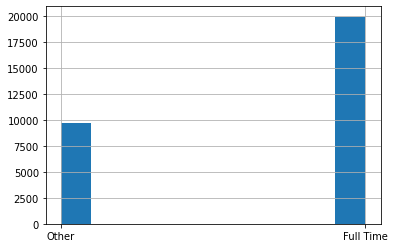

In [16]:
df['job_type_target'].hist()

In [17]:
df['job_type_target'].value_counts()

Full Time    19952
Other         9703
Name: job_type_target, dtype: int64

Now we can define the baseline accuracy for the models as below. Precision that is equal to or less than approximately 0.67 can therefore be treated as no improvement above the baseline

In [18]:
len(df[df['job_type_target'] == 'Full Time'])/len(df)

0.6728039116506491

Now split the data frame into train, test and validation then write the dataframe into a csv.

In [19]:
n = len(df)
n_train = int(df_args.train_proportion*n)
n_val = int(df_args.val_proportion*n)
n_test = int(df_args.test_proportion*n)

df['split'] = ['nil' for i in range(len(df))]

for idx, _ in df[:n_train].iterrows():
    df.loc[idx]['split'] = 'train'
for idx, _ in df[n_train:n_train+n_val].iterrows():
    df.loc[idx]['split'] = 'val'
for idx, _ in df[n_train+n_val:].iterrows():
    df.loc[idx]['split'] = 'test' 
df['split'].value_counts()

train    20758
test      5932
val       2965
Name: split, dtype: int64

In [20]:
df.job_description = df.job_description.apply(lambda x: ' '.join(x))
df.short_description = df.short_description.apply(lambda x: ' '.join(x)) # lists cannot be stored in csv
df.to_csv(df_args.processed_csv, index=False)
df

,category,job_description,job_type_target,short_description,split
0,Trades & Services,newcastle location car license required previo...,Other,advantage lawn regards strictly smoking common...,train
1,"Manufacturing, Transport & Logistics",beak johnston are industry leaders within the ...,Full Time,beak within chilled food beak food manufacturi...,train
2,Community Services & Development,the opportunity do you enjoy challenge love re...,Full Time,young people ymca territory youth community ym...,train
3,Real Estate & Property,work on one of the best property portfolios in...,Full Time,dexus communications funds communications inve...,train
4,Hospitality & Tourism,permanent position on offer for junior sous ch...,Full Time,permanent junior sous chef popular tourist des...,train
...,...,...,...,...,...
29995,Information & Communication Technology,junior net developer required for start up you...,Other,net start start youa tmll net development deve...,test
29996,Trades & Services,we are seeking general labourers hands for var...,Other,general labourers hands various assignments as...,test
29997,Sales,no industry experience no worries use your peo...,Other,industry people face face industry youa tmre p...,test
29998,Construction,this large building construction firm are look...,Full Time,sydeny cbd new builder developer yearsa needle...,test


## Creating word vectors to be used when training the models

In [21]:
vectorizer_args = Namespace(
    load_word2vec = True,
    word2vec_model_filepath = os.path.join(script_dir, 'model_storage/word2vec'),
)

#### Loading the pretrained glove model

In [22]:
def load_embedding_model():
    """ Load GloVe Vectors
        Return:
            wv_from_bin: All 400000 embeddings, each lengh 200
    """
    import gensim.downloader as api
    wv_pretrained = api.load("glove-wiki-gigaword-100")
    #print("Loaded vocab size %i" % len(wv_pretrained.key_to_index))
    print("The loaded object is of type %s" % str(type(wv_pretrained)))
    return wv_pretrained
glove_model = load_embedding_model()

The loaded object is of type <class 'gensim.models.keyedvectors.KeyedVectors'>


### Word embedding visualization with tsne and word2vec

First train or load a domain specific word2vec model

In [23]:
if vectorizer_args.load_word2vec:
    word2vec_model = Word2Vec.load(vectorizer_args.word2vec_model_filepath).wv # Model may not load on different OS so change vector_args

else:
    # Configuration was taken from labs
    word2vec = Word2Vec(min_count=1,
                        window=2, # We are trying to find "Full time"
                        size=100,
                        sample=6e-5, 
                        alpha=0.03, 
                        min_alpha=0.0007, 
                        negative=20,
                        workers=15)
    t = time()

    word2vec.build_vocab(df['job_description'], progress_per=10)

    print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))
    t = time()

    word2vec.train(df['job_description'], total_examples=word2vec.corpus_count, epochs=10, report_delay=1)
    word2vec_model = word2vec.wv
    word2vec_model.wv.save(vectorizer_args.word2vec_model_filepath)
    print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Define some functions to help with plotting the words

In [24]:
def interactive_tsne(text_labels, tsne_array):
    '''makes an interactive scatter plot with text labels for each point'''

    # Define a dataframe to be used by bokeh context
    bokeh_df = pd.DataFrame(tsne_array, text_labels, columns=['x','y'])
    bokeh_df['text_labels'] = bokeh_df.index

    # interactive controls to include to the plot
    TOOLS="hover, zoom_in, zoom_out, box_zoom, undo, redo, reset, box_select"

    p = figure(tools=TOOLS, plot_width=700, plot_height=700)

    # define data source for the plot
    source = ColumnDataSource(bokeh_df)

    # scatter plot
    p.scatter('x', 'y', source=source, fill_alpha=0.6,
              fill_color="#8724B5",
              line_color=None)

    # text labels
    labels = LabelSet(x='x', y='y', text='text_labels', y_offset=8,
                      text_font_size="8pt", text_color="#555555",
                      source=source, text_align='center')

    p.add_layout(labels)

    # show plot inline
    output_notebook()
    show(p)

In [25]:
def display_closestwords_tsnescatterplot(model, word, vec_length):
    
    arr = np.empty((0,vec_length), dtype='f')
    word_labels = [word]

    # get close words
    close_words = model.similar_by_word(word)
    
    # add the vector for each of the closest words to the array
    arr = np.append(arr, np.array([model[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    # display scatter plot
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.title(f'Words closest to: {word}')
    plt.show()

Below plot shows the distribution of some example words of the domain specific word2vec that was trained previously

In [27]:
vocab  = word2vec_model.index_to_key[:100]
random.shuffle(vocab)
vocab = [word for word in vocab if word not in stopwords]
X = word2vec_model[vocab]
tsne = TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(X)
interactive_tsne(list(vocab), X_tsne)

/Users/omriram/Desktop/U/cits4012/cits4012_environment/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/omriram/Desktop/U/cits4012/cits4012_environment/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Loading BokehJS ...

Now plot the same words but on the pretrained glove model

In [29]:
vocab = [word for word in vocab if word in glove_model.key_to_index]
X = glove_model[vocab]
tsne = TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(X)
interactive_tsne(list(vocab), X_tsne)

/Users/omriram/Desktop/U/cits4012/cits4012_environment/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/omriram/Desktop/U/cits4012/cits4012_environment/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Loading BokehJS ...

The most obvious difference in the plotting of the two embeddings is that the domain specific seem to closely associate words that would appear together often in job postings. Thus domain specific semantics may be extracted by training this model and may prove advantageous later when we use its embeddings to train the classifiers.

#### Closest words comparison

A better indication for the differences between the two embedding models would be a plot of a common word with their closest neighbours

/Users/omriram/Desktop/U/cits4012/cits4012_environment/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/omriram/Desktop/U/cits4012/cits4012_environment/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


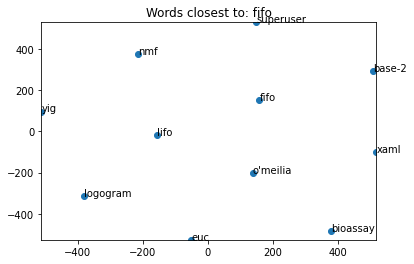

In [30]:
display_closestwords_tsnescatterplot(glove_model, 'fifo', 100)

/Users/omriram/Desktop/U/cits4012/cits4012_environment/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/omriram/Desktop/U/cits4012/cits4012_environment/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


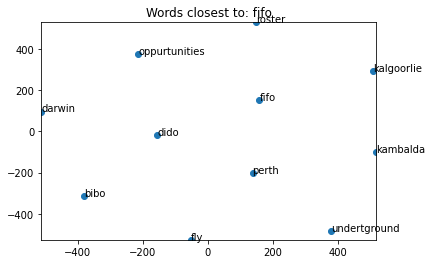

In [32]:
display_closestwords_tsnescatterplot(word2vec_model, 'fifo', 100)

The above plots better communicate how the closest words are highly dependent on the source of the dataset that the embeddings were derived from. For example perth is a close word to fifo in the domain specific model but not in the pretrained glove model. This is because perth has many fifo job postings but the glove model could not have picked up on that.